In [1]:
!ls

sample_data


In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#https://drive.google.com/open?id=1zglOX-AkDkXV3SAiUcQEm0gssYF3FrVZ

download = drive.CreateFile({'id': '1zglOX-AkDkXV3SAiUcQEm0gssYF3FrVZ'})
download.GetContentFile('Flickr8k.zip')



    100% |████████████████████████████████| 993kB 19.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
#https://drive.google.com/open?id=10mMJv6xoKqIMPv4Q1ps8tgbha9_IDWnb
download = drive.CreateFile({'id': '10mMJv6xoKqIMPv4Q1ps8tgbha9_IDWnb'})
download.GetContentFile('model_4_3.h5')


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:

#https://drive.google.com/drive/folders/1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3
uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'features.pkl'})
uploaded.SetContentFile('features.pkl')
uploaded.Upload()

In [0]:
uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'descriptions.txt'})
uploaded.SetContentFile('descriptions.txt')
uploaded.Upload()

In [5]:
!ls

adc.json  Flickr8k.zip	model_4_3.h5  sample_data


In [6]:
!python --version

Python 3.6.7


In [0]:
!unzip Flickr8k.zip

In [3]:
import numpy as np
import pandas as pd
import cv2
import time
import os
import matplotlib.pyplot as plt
import pickle
import string
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
#import shutil #dont use shutil it deletes files


Using TensorFlow backend.


In [4]:
def extract_features():
  iterlist=os.listdir('Flickr8k/Flicker8k_Dataset/')
  model=VGG16()
  model.layers.pop()
  model=Model(inputs=model.inputs,outputs=model.layers[-1].output)
  print(model.summary())
  features=dict()
  for name in iterlist:
    img=load_img('Flickr8k/Flicker8k_Dataset/'+name,target_size=(224,224))
    img=img_to_array(img)
    img=img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img=preprocess_input(img)
    feature=model.predict(img)
    img_id=name.split('.')[0]
    features[img_id]=feature
    print(name)
    
  return features

start=time.time()
features=extract_features()
end=time.time()
print(end-start)
print(len(features))
pickle.dump(features,open('features.pkl','wb'))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [5]:
iterlist=os.listdir('Flickr8k/Flicker8k_Dataset/')
t=features[iterlist[0].split('.')[0]]
t.shape
t

array([[0.8426734, 6.3703494, 0.       , ..., 0.       , 0.4112926,
        0.       ]], dtype=float32)

In [0]:
def load_doc(fname):
  fp=open(fname,'r')
  txt=fp.read()
  fp.close()
  return txt

fname='Flickr8k/Flickr8k_text/Flickr8k.token.txt'
doc=load_doc(fname)

In [7]:
t=doc.split('\n')
print(t[1].split())
' '.join(t[1].split())

['1000268201_693b08cb0e.jpg#1', 'A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.']


'1000268201_693b08cb0e.jpg#1 A girl going into a wooden building .'

In [8]:
def load_descriptions(doc):
  mapping=dict()
  for line in doc.split('\n'):
    tokens=line.split()
    if(len(line))<2:
      continue
    
    img_id,img_desc=tokens[0].split('.')[0],' '.join(tokens[1:])
    
    if img_id not in mapping:
      mapping[img_id]=list()
    
    mapping[img_id].append(img_desc)
  return mapping

start=time.time()
descriptions=load_descriptions(doc)
end=time.time()
print(len(descriptions))
print(end - start)

8092
0.11665916442871094


In [9]:
def clean_descriptions(descriptions):
  table=str.maketrans('','',string.punctuation)
  for key,desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc=desc_list[i].split()
      desc=[w.lower() for w in desc]
      desc=[w.translate(table) for w in desc]
      desc=[w for w in desc if len(w)>1]
      desc=[w for w in desc if w.isalpha()]
      desc_list[i]=' '.join(desc)
      
start=time.time()      
clean_descriptions(descriptions)
end=time.time()
print(end-start)

0.5143294334411621


In [10]:
def to_vocabulary(descriptions):
  vocab=set()
  for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
  return vocab      

vocabulary=to_vocabulary(descriptions)
print(len(vocabulary))

def save_descriptions(descriptions,fname):
  lines=list()
  for key,desc_list in descriptions.items():
    for sentence in desc_list:
      lines.append(key+' '+sentence)
      
    data= '\n'.join(lines)
    fp=open(fname,'w')
    fp.write(data)
    fp.close()
    
start=time.time()
save_descriptions(descriptions,'descriptions.txt')
end=time.time()
print(end-start)  

8763
92.25887322425842


In [11]:
def load_set(fname):
  doc=load_doc(fname)
  dataset=list()
  for line in doc.split('\n'):
    if len(line)<1:
      continue
    identifier=line.split('.')[0]
    dataset.append(identifier)

  return set(dataset)

def load_clean_descriptions(fname,dataset):
  doc=load_doc(fname)
  descriptions = dict()
  for line in doc.split('\n'):
    tokens=line.split()
    img_id,img_desc=tokens[0],tokens[1:]
    if img_id in dataset:
      if img_id not in descriptions:
        descriptions[img_id]=list()
      
      desc='startseq ' + ' '.join(img_desc) + ' endseq'
      #print(img_id,img_desc)
      descriptions[img_id].append(desc)
      #print(img_id,descriptions[img_id])
  
  return descriptions

def load_photo_features(fname,dataset):
  all_features=pickle.load(open(fname,'rb'))
  features={k:all_features[k] for k in dataset}
  return features

fname='Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train=load_set(fname)
print(len(train))
train_descriptions=load_clean_descriptions('descriptions.txt',train)
print(len(train_descriptions))
train_features=load_photo_features('features.pkl',train)
print(len(train_features))

6000
6000
6000


In [12]:

def to_lines(descriptions):
  all_desc=list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

def create_tokenizer(descriptions):
  lines=to_lines(descriptions)
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

tokenizer=create_tokenizer(train_descriptions)
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

7579


In [0]:
def create_sequences(tokenizer, max_length, descriptions, photos):
  x1,x2,y=list(),list(),list()
  
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      seq=tokenizer.texts_to_sequences([desc])[0]
      
      for i in range(1,len(seq)):
        in_seq,out_seq=seq[:i],seq[i]
        in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
        out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
        
        x1.append(photos[key][0])
        x2.append(in_seq)
        y.append(out_seq)
        
  return np.array(x1),np.array(x2),np.array(y)


def max_length(descriptions):
  lines=to_lines(descriptions)
  return max(len(d.split()) for d in lines)

def define_model(vocab_size,max_length):
  inputs1=Input(shape=(4096,))
  
  # feature extractor
  fe1=Dropout(0.5)(inputs1)
  fe2=Dense(256,activation='relu')(fe1)
  
  # sequence processor
  inputs2=Input(shape=(max_length,))
  se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
  se2=Dropout(0.5)(se1)
  se3=LSTM(256)(se2)
  
  # decoder
  decoder1=add([fe2,se3])
  decoder2=Dense(256,activation='relu')(decoder1)
  outputs=Dense(vocab_size,activation='softmax')(decoder2)
  
  model=Model(inputs=[inputs1,inputs2],outputs=[outputs])
  model.compile(loss='categorical_crossentropy',optimizer='adam')
  
  print(model.summary())
  plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
  
  #plot_model(model,to_file='model_expandnested.png',show_shapes=True,show_layer_names=True,expand_nested=True)
  
  return model

#mask_zero: Whether or not the input value 0 is a special "padding"
#value that should be masked out. This is useful when using 
#recurrent layers which may take variable length input. If this 
#is True then all subsequent layers in the model need to support 
#masking or an exception will be raised. If mask_zero is set to 
#True, as a consequence, index 0 cannot be used in the vocabulary
#(input_dim should equal size of vocabulary + 1).

In [0]:
max_len=max_length(train_descriptions)
print(max_len)

x1train,x2train,ytrain=create_sequences(tokenizer,max_len,train_descriptions,train_features)

fname='Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
test=load_set(fname)
print(len(test))
test_descriptions=load_clean_descriptions('descriptions.txt',test)
test_features=load_photo_features('features.pkl',test)
print(len(test_features))

x1test,x2test,ytest=create_sequences(tokenizer,max_len,test_descriptions,test_features)

model=define_model(vocab_size,max_len)

filepath='model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

checkpoint=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

tensorboard=TensorBoard(log_dir="logs/{}".format(time()))

#model.fit([x1train,x2train],ytrain,epochs=10,verbose=2,callbacks=[checkpoint,tensorboard],validation_data=([x1test,x2test],ytest))


34


In [0]:
def data_generator(descriptions,photos,tokenizer,max_len):
  while True:
    for key, desc_list in descriptions.items():
      photo=photos[key][0]
      in_img,in_seq,out_word=create_sequences(tokenizer,max_len,desc_list,photo)
      
      yield [[in_img,in_seq],out_word]

In [0]:
def create_sequences(tokenizer, max_length, desc_list, photo):
  x1,x2,y=list(),list(),list()
  
  for desc in  desc_list:
    
    seq=tokenizer.texts_to_sequences([desc])[0]
      
    for i in range(1,len(seq)):
        in_seq,out_seq=seq[:i],seq[i]
        in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
        out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
        
        x1.append(photo)
        x2.append(in_seq)
        y.append(out_seq)
        
        if(i%100==0):
          print(i)
        
  return np.array(x1),np.array(x2),np.array(y)

In [16]:
max_len=max_length(train_descriptions)
print(max_len)

start=time.time()

generator=data_generator(train_descriptions,train_features,tokenizer,max_len)
inputs,outputs=next(generator)

end=time.time()
print(end-start)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

34
0.004063129425048828
(47, 4096)
(47, 34)
(47, 7579)


In [17]:
fname='Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
test=load_set(fname)
print(len(test))
test_descriptions=load_clean_descriptions('descriptions.txt',test)
test_features=load_photo_features('features.pkl',test)
print(len(test_features))


1000
1000


In [18]:
epochs2=10
steps=len(train_descriptions)
model=define_model(vocab_size,max_len)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]               

In [0]:

start=time.time()
for i in range(epochs2):
  
  generator=data_generator(train_descriptions,train_features,tokenizer,max_len)
  
  generator_test=data_generator(test_descriptions,test_features,tokenizer,max_len)
  #filepath='model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

  #tensorboard=TensorBoard(log_dir="logs/{}".format(time()))

  #checkpoint=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
  #model.fit_generator(generator,epochs=10,verbose=2,callbacks=[checkpoint],validation_data=generator_test)

  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('model_'+str(i)+'.h5')

end=time.time()
print(end-start)

1000
1000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 34, 256)      1940224     input_11[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 4096)         0           input_10[0][0]                   
__________________________________________________________________________________________________


In [0]:
!ls

adc.json	  Flickr8k	model_1.h5  model_4.h5	model_7.h5  model.png
descriptions.txt  Flickr8k.zip	model_2.h5  model_5.h5	model_8.h5  sample_data
features.pkl	  model_0.h5	model_3.h5  model_6.h5	model_9.h5


In [0]:
epochs3=5
start=time.time()
for i in range(epochs3):
  
  generator=data_generator(train_descriptions,train_features,tokenizer,max_len)
  
  generator_test=data_generator(test_descriptions,test_features,tokenizer,max_len)
  
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('model_'+str(i)+'.h5')

end=time.time()
print(end-start)

Epoch 1/1
6000/6000 [==============================] - 763s 127ms/step - loss: 3.1381
Epoch 1/1
6000/6000 [==============================] - 755s 126ms/step - loss: 3.1202
Epoch 1/1
6000/6000 [==============================] - 758s 126ms/step - loss: 3.1129
Epoch 1/1
6000/6000 [==============================] - 768s 128ms/step - loss: 3.0991
Epoch 1/1
6000/6000 [==============================] - 760s 127ms/step - loss: 3.0909
3804.400270462036


In [0]:
!ls

adc.json	  Flickr8k	model_1.h5  model_4.h5	model_7.h5  model.png
descriptions.txt  Flickr8k.zip	model_2.h5  model_5.h5	model_8.h5  sample_data
features.pkl	  model_0.h5	model_3.h5  model_6.h5	model_9.h5


In [0]:
epochs3=5
start=time.time()
for i in range(epochs3):
  
  generator=data_generator(train_descriptions,train_features,tokenizer,max_len)
  
  generator_test=data_generator(test_descriptions,test_features,tokenizer,max_len)
  
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('model_'+str(i)+'_3'+'.h5')

end=time.time()
print(end-start)

Epoch 1/1
6000/6000 [==============================] - 744s 124ms/step - loss: 3.0851
Epoch 1/1
6000/6000 [==============================] - 751s 125ms/step - loss: 3.0806
Epoch 1/1
6000/6000 [==============================] - 754s 126ms/step - loss: 3.0764
Epoch 1/1
6000/6000 [==============================] - 759s 126ms/step - loss: 3.0743
Epoch 1/1
6000/6000 [==============================] - 770s 128ms/step - loss: 3.0722
3779.222267150879


In [0]:
upl=os.listdir()
print(upl)
#upl.pop(11)
#upl.pop(14)
upl.remove('Flickr8k.zip')
upl.remove('Flickr8k')
upl.remove('.config')
#upl.pop(0)
print(upl)


['.config', 'model.png', 'model_2_3.h5', 'features.pkl', 'model_1_3.h5', 'model_1.h5', 'model_2.h5', 'model_4_3.h5', 'model_6.h5', 'model_4.h5', 'model_9.h5', 'Flickr8k.zip', 'model_3.h5', 'model_7.h5', 'Flickr8k', 'model_3_3.h5', 'model_0_3.h5', 'descriptions.txt', 'model_8.h5', 'adc.json', 'model_0.h5', 'model_5.h5', 'sample_data']
['model.png', 'model_2_3.h5', 'features.pkl', 'model_1_3.h5', 'model_1.h5', 'model_2.h5', 'model_4_3.h5', 'model_6.h5', 'model_4.h5', 'model_9.h5', 'model_3.h5', 'model_7.h5', 'model_3_3.h5', 'model_0_3.h5', 'descriptions.txt', 'model_8.h5', 'adc.json', 'model_0.h5', 'model_5.h5', 'sample_data']


In [19]:
!ls

adc.json	  features.pkl	Flickr8k.zip  model.png
descriptions.txt  Flickr8k	model_4_3.h5  sample_data


# Evaluate

In [0]:
def word_for_id(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None
  
def generate_desc(model,tokenizer,photo,max_len):
  in_text='startseq'
  
  for i in range(max_len):
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    
    sequence=pad_sequences([sequence],maxlen=max_len)
    
    yhat=model.predict([photo,sequence],verbose=0)
    yhat=np.argmax(yhat)
    
    word=word_for_id(yhat,tokenizer)
    
    if word is None:
      break
      
    in_text += ' '+word
    
    if word=='endseq':
      break
      
  return in_text

In [0]:
def evaluate_model(model,descriptions,photos,tokenizer,max_len):
  actual,predicted=list(),list()
  for key,desc_list in descriptions.items():
    yhat=generate_desc(model,tokenizer,photos[key],max_len)
    
    references=[d.split() for d in desc_list]
    
    actual.append(references)
    predicted.append(yhat.split())
  
  return actual,predicted
  

In [37]:
start=time.time()
model_final=load_model('model_4_3.h5')
actual,predicted=evaluate_model(model_final,test_descriptions,test_features,tokenizer,max_len)
end=time.time()
print(end-start)

443.1329472064972


In [38]:
print('BLEU -1 : %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print('BLEU -2 : %f' % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
print('BLEU -3 : %f' % corpus_bleu(actual,predicted,weights=(0.3,0.3,0.3,0)))
print('BLEU -4 : %f' % corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))

BLEU -1 : 0.505694
BLEU -2 : 0.257299
BLEU -3 : 0.173234
BLEU -4 : 0.077892


In [0]:
import pickle
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

In [45]:
len(actual),len(predicted)

(1000, 1000)

In [0]:
pickle.dump(actual,open('actual.pkl','wb'))

In [0]:
pickle.dump(predicted,open('predicted.pkl','wb'))

In [50]:
!ls

actual.pkl	  features.pkl	model_4_3.h5   sample_data
adc.json	  Flickr8k	model.png      tokenizer.pkl
descriptions.txt  Flickr8k.zip	predicted.pkl


In [51]:
os.listdir()

['.config',
 'model_4_3.h5',
 'Flickr8k',
 'features.pkl',
 'actual.pkl',
 'predicted.pkl',
 'model.png',
 'Flickr8k.zip',
 'descriptions.txt',
 'tokenizer.pkl',
 'adc.json',
 'sample_data']

In [104]:
templist=os.listdir()
savelist=[]
for i in range(len(templist)):
  print(i,templist[i])

0 .config
1 model_working.png
2 Flickr8k
3 features.pkl
4 actual.pkl
5 predicted.pkl
6 Flickr8k.zip
7 descriptions.txt
8 working_model_files
9 tokenizer.pkl
10 working_model_files.zip
11 adc.json
12 model_working.h5
13 sample_data


In [0]:
savelist.extend(templist[1:2])
savelist.extend(templist[3:6])

savelist.extend(templist[7:8])
savelist.extend(templist[9:10])

savelist.extend(templist[12:13])

In [106]:
len(savelist),savelist

(7,
 ['model_working.png',
  'features.pkl',
  'actual.pkl',
  'predicted.pkl',
  'descriptions.txt',
  'tokenizer.pkl',
  'model_working.h5'])

In [0]:
model.save('model_working.h5')
save_descriptions(descriptions,'descriptions.txt')


In [0]:
pickle.dump(features,open('features.pkl','wb'))
plot_model(model,to_file='model_working.png',show_shapes=True,show_layer_names=True)


In [0]:

#files = ['file1.txt', 'file2.txt', 'file3.txt']
#for f in savelist:
#    shutil.move(f, 'working_model_files')

In [103]:
!ls

actual.pkl	  Flickr8k.zip	     tokenizer.pkl
adc.json	  model_working.h5   working_model_files
descriptions.txt  model_working.png  working_model_files.zip
features.pkl	  predicted.pkl
Flickr8k	  sample_data


  adding: working_model_files (deflated 53%)


In [0]:
for item in savelist:
  uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
  uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'Working_'+item})
  uploaded.SetContentFile(item)
  uploaded.Upload()  
  

# Dayum nigga, Done!

In [0]:
tokenizer=pickle.load(open('tokenizer.pkl','rb'))
max_len=34
model2=load_model('model_4_3.h5')

In [0]:
def extract_features(filename):
  model=VGG16()
  model.layers.pop()
  model=Model(inputs=model.inputs,outputs=model.layers[-1].output)
  image=load_img(filename,target_size=(224,224))
  image=img_to_array(image)
  image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  image=preprocess_input(image)
  feature=model.predict(image,verbose=0)

  return feature

In [0]:
fname='Flickr8k/Flicker8k_Dataset/145721498_a27d2db576.jpg'
photo=extract_features(fname)


In [165]:
lf=os.listdir('Flickr8k/Flicker8k_Dataset/')
lf.index('1305564994_00513f9a5b.jpg')

1562

In [147]:
lf[7]

'3498482871_4e02f31c35.jpg'

In [0]:
test

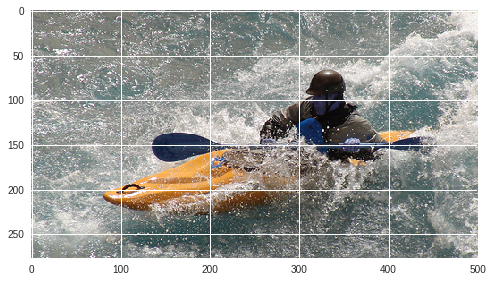

In [166]:
import cv2
img=cv2.imread(fname)
plt.imshow(img)

In [167]:
descr=generate_desc(model2,tokenizer,photo,max_len)
print(descr)

startseq boy is swimming underwater in pool endseq


In [146]:
print(actual[7])

[['startseq', 'boy', 'in', 'blue', 'shorts', 'slides', 'down', 'slide', 'into', 'pool', 'endseq'], ['startseq', 'boy', 'in', 'blue', 'swimming', 'trunks', 'slides', 'down', 'yellow', 'slide', 'into', 'wading', 'pool', 'with', 'inflatable', 'toys', 'floating', 'in', 'the', 'water', 'endseq'], ['startseq', 'boy', 'rides', 'down', 'slide', 'into', 'small', 'backyard', 'pool', 'endseq'], ['startseq', 'boy', 'sliding', 'down', 'slide', 'into', 'pool', 'with', 'colorful', 'tubes', 'endseq'], ['startseq', 'child', 'is', 'falling', 'off', 'slide', 'onto', 'colored', 'balloons', 'floating', 'on', 'pool', 'of', 'water', 'endseq']]


In [139]:
print(predicted[7])

['startseq', 'young', 'boy', 'is', 'playing', 'with', 'red', 'popsicle', 'endseq']


In [157]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
download = drive.CreateFile({'id': '10mMJv6xoKqIMPv4Q1ps8tgbha9_IDWnb'})
download.GetContentFile('model_4_3.h5')

model = load_model('model_4_3.h5')
# load and prepare the photograph
fname='Flickr8k/Flicker8k_Dataset/145721498_a27d2db576.jpg'

photo = extract_features(fname)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq boy is swimming underwater in pool endseq


In [156]:
!ls

actual.pkl	  Flickr8k.zip	     tokenizer.pkl
adc.json	  model_working.h5   working_model_files
descriptions.txt  model_working.png  working_model_files.zip
features.pkl	  predicted.pkl
Flickr8k	  sample_data


# rough


In [0]:
for item in upl:
  uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
  uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : item})
  uploaded.SetContentFile(item)
  uploaded.Upload()  

In [0]:
uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'descriptions.txt'})
uploaded.SetContentFile('descriptions.txt')
uploaded.Upload()

In [0]:
!ls

sample_data


In [0]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# summarize what was learned
print(t.word_counts)
print(t.document_count)
print('word_index is',len(t.word_index),t.word_index)
print(t.word_docs)
# integer encode documents
encoded_docs = t.texts_to_matrix(docs, mode='count')
print(encoded_docs)
pl=t.texts_to_sequences(['nice work'])
print(pl,len(pl),pl[0],len(pl[0]))

OrderedDict([('well', 1), ('done', 1), ('good', 1), ('work', 2), ('great', 1), ('effort', 1), ('nice', 1), ('excellent', 1)])
5
word_index is 8 {'work': 1, 'well': 2, 'done': 3, 'good': 4, 'great': 5, 'effort': 6, 'nice': 7, 'excellent': 8}
defaultdict(<class 'int'>, {'done': 1, 'well': 1, 'work': 2, 'good': 1, 'great': 1, 'effort': 1, 'nice': 1, 'excellent': 1})
[[0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[7, 1]] 1 [7, 1] 2


In [0]:
pt=pad_sequences([pl],maxlen=5)
print(pt,pt.shape)
print(pt[0],pt[0].shape)

[[[0 0]
  [0 0]
  [0 0]
  [0 0]
  [7 1]]] (1, 5, 2)
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [7 1]] (5, 2)


In [0]:
!ls

adc.json  descriptions.txt  features.pkl  Flickr8k  Flickr8k.zip  sample_data


In [0]:
!ls

adc.json  descriptions.txt  features.pkl  Flickr8k  Flickr8k.zip  sample_data


In [0]:
2+2

4

In [0]:
del dict

In [0]:
dict()

{}

In [0]:
dict1 = {"a": "123", "b": "456", "c": "789"}
string = "abc"
print(string.maketrans(dict1))
tt=string.maketrans(dict1)
string.translate(tt)

{97: '123', 98: '456', 99: '789'}


'123456789'

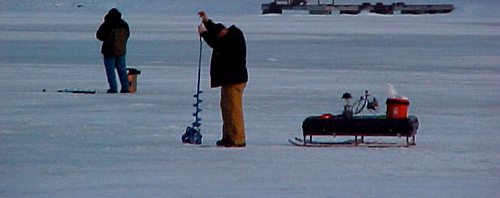

In [0]:
iterlist=os.listdir('Flickr8k/Flicker8k_Dataset/')
load_img('Flickr8k/Flicker8k_Dataset/'+iterlist[0])

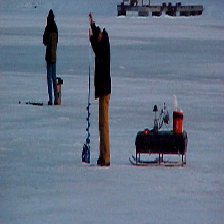

In [0]:
img=load_img('Flickr8k/Flicker8k_Dataset/'+iterlist[0],target_size=(224,224))
img

In [0]:
img=img_to_array(img)
print(img.shape)
print(img)

(224, 224, 3)
[[[102. 119. 135.]
  [103. 120. 138.]
  [ 98. 115. 135.]
  ...
  [ 86. 105. 135.]
  [ 89. 108. 138.]
  [ 86. 105. 135.]]

 [[102. 119. 137.]
  [106. 123. 141.]
  [101. 118. 138.]
  ...
  [ 88. 105. 135.]
  [ 88. 105. 135.]
  [ 87. 104. 134.]]

 [[ 98. 115. 135.]
  [100. 117. 137.]
  [102. 118. 141.]
  ...
  [ 93. 108. 139.]
  [ 92. 105. 137.]
  [ 93. 106. 138.]]

 ...

 [[ 98. 114. 130.]
  [101. 114. 133.]
  [ 95. 110. 131.]
  ...
  [118. 125. 153.]
  [118. 123. 152.]
  [118. 123. 152.]]

 [[ 99. 117. 137.]
  [101. 113. 135.]
  [102. 116. 142.]
  ...
  [118. 125. 151.]
  [118. 125. 151.]
  [118. 125. 151.]]

 [[102. 118. 141.]
  [104. 114. 141.]
  [110. 121. 149.]
  ...
  [117. 125. 148.]
  [117. 125. 148.]
  [116. 124. 147.]]]


In [0]:
img=preprocess_input(img)
img

array([[[ 31.060997  ,   2.2210007 , -21.68      ],
        [ 34.060997  ,   3.2210007 , -20.68      ],
        [ 31.060997  ,  -1.7789993 , -25.68      ],
        ...,
        [ 31.060997  , -11.778999  , -37.68      ],
        [ 34.060997  ,  -8.778999  , -34.68      ],
        [ 31.060997  , -11.778999  , -37.68      ]],

       [[ 33.060997  ,   2.2210007 , -21.68      ],
        [ 37.060997  ,   6.2210007 , -17.68      ],
        [ 34.060997  ,   1.2210007 , -22.68      ],
        ...,
        [ 31.060997  , -11.778999  , -35.68      ],
        [ 31.060997  , -11.778999  , -35.68      ],
        [ 30.060997  , -12.778999  , -36.68      ]],

       [[ 31.060997  ,  -1.7789993 , -25.68      ],
        [ 33.060997  ,   0.22100067, -23.68      ],
        [ 37.060997  ,   1.2210007 , -21.68      ],
        ...,
        [ 35.060997  ,  -8.778999  , -30.68      ],
        [ 33.060997  , -11.778999  , -31.68      ],
        [ 34.060997  , -10.778999  , -30.68      ]],

       ...,

      

In [0]:
len(os.listdir('Flickr8k/Flicker8k_Dataset/'))

8091

In [0]:
model=VGG16()
print(model.summary())
model.inputs

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 14s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

[<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>]

In [0]:
ffrom google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [0]:
#https://drive.google.com/drive/folders/1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3
uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'features'})
uploaded.SetContentFile('features.pkl')
uploaded.Upload()

In [0]:
uploadId = '1LDCrJpp7e9OZh3jRpoJh47v22huRssQ9'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'LSTMH52SIG_TRUE'})
uploaded.SetContentFile('LSTMmodelSIG_TRUE.h5')
uploaded.Upload()
                #dataName=chkName+".data-00000-of-00001"
                #check="data/"+dataName
                

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTMmodelSIG_TRUE.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("LSTMmodelSIG_TRUE.h5")
print("Saved model to disk")
 
  
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))